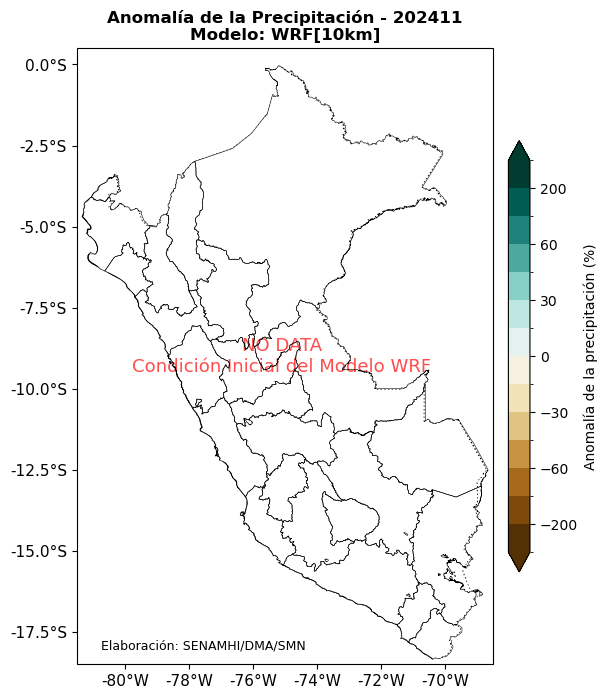

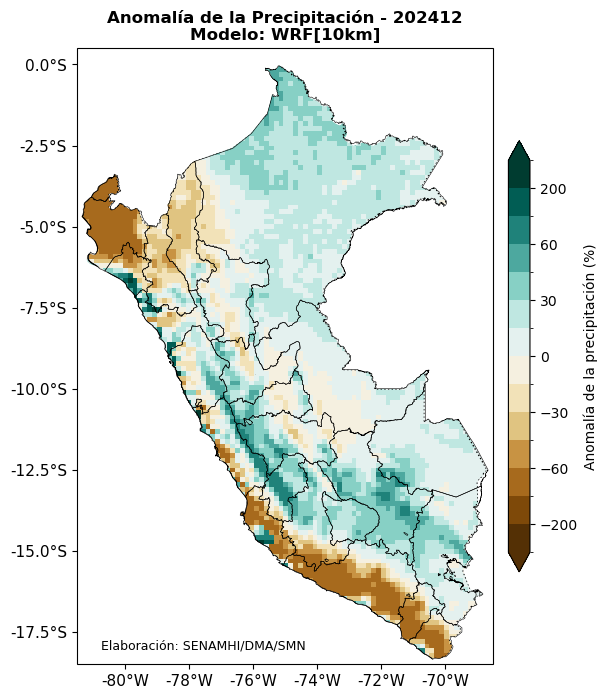

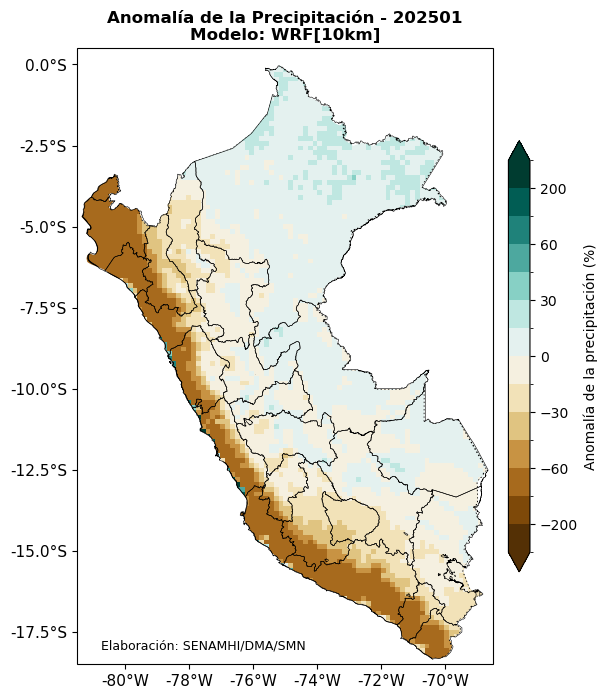

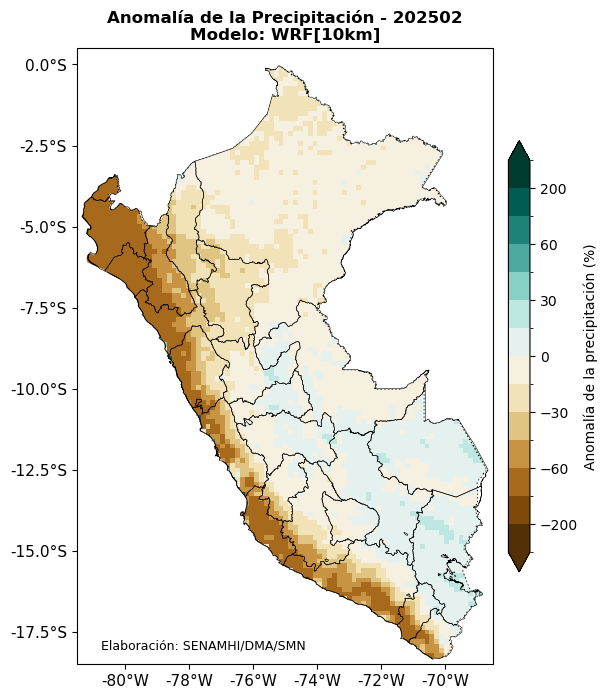

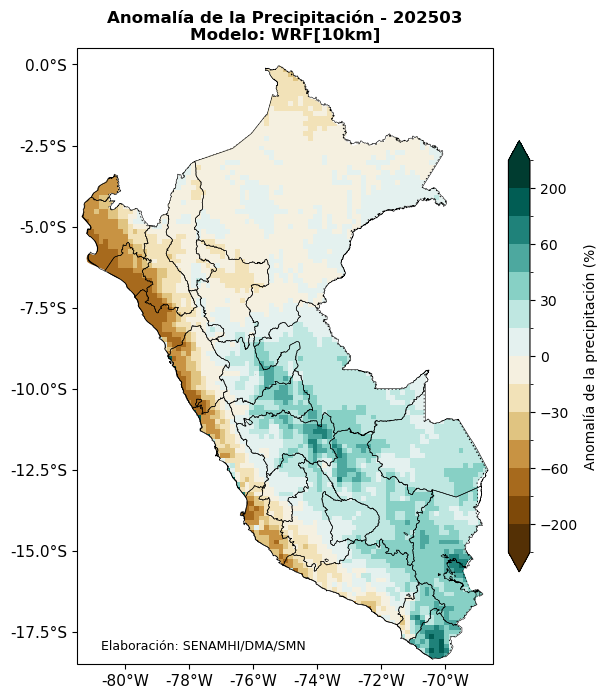

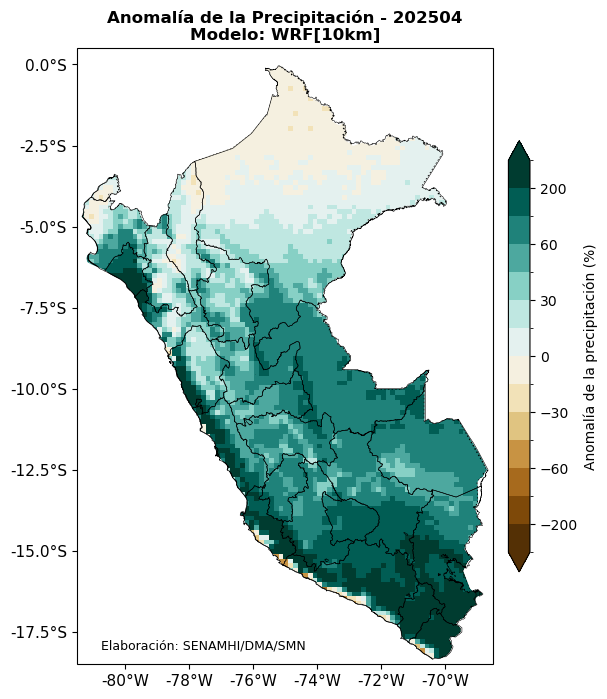

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
from matplotlib.colors import BoundaryNorm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import cartopy.feature as cfeature
import os

base_year = 2024
base_month = 11
base_date_str = f"{base_year}{base_month:02d}"

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

# Rutas de los archivos NetCDF
archivo_pronostico = f"/scratch/DMA/SMN/CLIMA/c3s_cfsv2/wrf391/wrf_post/{base_year}/{base_month}/lluvia/mes_ensemble_pp_peru.nc"
archivo_climatologia = f"/scratch/DMA/SMN/CLIMA/enandes/respaldo/BKrespaldo/CLUSTER-COMPLEMENTARIO/EXTRACCION-CLIM/{base_month}-1982.2010/lluvia/prom.pp.clima.nc"

# Rutas de los shapefiles
ruta_shapefile_sudamerica = '/scratch/shape/SHAPES/SUDA_NUEVO_SIN_PERU_3.shp'
ruta_shapefile_peru = '/scratch/shape/PER/DEPARTAMENTOS.shp'

# Cargar los shapefiles
sudamerica = gpd.read_file(ruta_shapefile_sudamerica)  # Shapefile de Sudamérica sin Perú
peru = gpd.read_file(ruta_shapefile_peru)  # Shapefile de los departamentos de Perú

# Verificar si el CRS coincide y transformar si es necesario
if sudamerica.crs != peru.crs:
    sudamerica = sudamerica.to_crs(peru.crs)

# Abrir los archivos NetCDF sin decodificar el tiempo
ds_pronostico = xr.open_dataset(archivo_pronostico, decode_times=False)
ds_climatologia = xr.open_dataset(archivo_climatologia, decode_times=False)
# Extraer el año y mes base desde los atributos de 'time'
time_units = ds_pronostico['time'].attrs['units']
fecha_base_str = time_units.split('since')[-1].strip()
fecha_base = datetime.strptime(fecha_base_str, "%Y-%m-%d %H:%M:%S")

# Acceder a las variables de precipitación (variable 'p')
pronostico_lluvia = ds_pronostico['p']
climatologia_lluvia = ds_climatologia['p']

# Definir los niveles personalizados
niveles = np.concatenate([np.arange(-300, -60, 100), np.arange(-60, 61, 15), np.arange(100, 301, 100)])
norm = BoundaryNorm(niveles, ncolors=256)

# Calcular la fecha del primer tiempo
meses_desde_base = ds_pronostico['time'].isel(time=0).values
fecha_primer_tiempo = add_months_to_date(fecha_base, int(meses_desde_base))

# Crear la carpeta con el nombre basado en la fecha del mes anterior al primer tiempo
fecha_anterior = add_months_to_date(fecha_primer_tiempo, -1)
carpeta_anterior = f'{fecha_anterior.year}{fecha_anterior.month:02d}'
ruta_carpeta = f'/scratch/DMA/SMN/CLIMA/web_figuras/prediccion/mensual/{carpeta_anterior}'

if not os.path.exists(ruta_carpeta):
    os.makedirs(ruta_carpeta)

# Graficar la imagen de "NO DATA" para la fecha carpeta_anterior con barra de colores y ejes
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-81.5, -68.5, -18.5, 0.5], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Añadir la barra de colores vacía con ajuste
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='BrBG'), 
                    ax=ax, orientation='vertical', pad=0.02, 
                    extend='both', shrink=0.7, aspect=20)
cbar.set_label('Anomalía de la precipitación (%)')

# Añadir texto "NO DATA"
ax.text(0.5, 0.5, 'NO DATA \nCondición Inicial del Modelo WRF ', 
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=13, color='red', alpha=0.7)

# Configurar las etiquetas de latitud y longitud
ax.set_xticks(np.arange(-80, -68, 2), crs=ccrs.PlateCarree())  # Longitudes
ax.set_yticks(np.arange(-17.5, 2.5, 2.5), crs=ccrs.PlateCarree())  # Latitudes
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°S'))
# Ajustar el tamaño de la fuente de los ticks en los ejes
ax.tick_params(axis='both', which='major', labelsize=11)  # Cambia el valor

# Ajustar el tamaño de la fuente de los ticks en los ejes
ax.tick_params(axis='both', which='major', labelsize=11)

# Añadir la leyenda de texto en la parte inferior derecha
ax.text(0.55, 0.02, 'Elaboración: SENAMHI/DMA/SMN', 
        horizontalalignment='right', verticalalignment='bottom', 
        transform=ax.transAxes, fontsize=9, color='black', 
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Añadir la máscara de Sudamérica sin Perú (enmascarar áreas fuera de Perú)
sudamerica.plot(ax=ax, color='white', edgecolor='none', zorder=2)

# Añadir el shapefile de los departamentos de Perú al final
peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4, zorder=3)

# Título de la gráfica
plt.title(f'Anomalía de la Precipitación - {carpeta_anterior}\nModelo: WRF[10km]' , fontsize=12, fontweight='bold')

# Guardar el gráfico en la carpeta creada
ruta_archivo = os.path.join(ruta_carpeta, f'pre_smnwrf_{carpeta_anterior}_anomPrec_wrf.png')
plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# Graficar las anomalías para los otros 5 tiempos
for i in range(5):
    # Calcular la fecha real sumando los meses al tiempo base
    meses_desde_base = ds_pronostico['time'].isel(time=i).values
    fecha_real = add_months_to_date(fecha_base, int(meses_desde_base))
    year = fecha_real.year
    month = fecha_real.month
    
    # Formatear la fecha en formato YYYYMM
    fecha_str = f'{year}{month:02d}'
    
    # Seleccionar el tiempo correspondiente en ambos datasets
    pronostico_lluvia_t = pronostico_lluvia.isel(time=i)
    climatologia_lluvia_t = climatologia_lluvia.isel(time=i)
    
    # Calcular la anomalía porcentual de la precipitación para el tiempo actual
    anomalia_porcentual_lluvia_t = ((pronostico_lluvia_t - climatologia_lluvia_t) / climatologia_lluvia_t) * 100
    
    # Crear el gráfico de la anomalía porcentual
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Definir los límites geográficos para Perú
    lon_min, lon_max = -81.5, -68.5
    lat_min, lat_max = -18.5, 0.5
        # Graficar la anomalía porcentual
    img = anomalia_porcentual_lluvia_t.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', norm=norm, add_colorbar=False)
   
    # Configurar los límites del mapa para Perú
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    
    # Añadir líneas de costa y fronteras
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Añadir la barra de colores con ajustes
    cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, 
                        extend='both', shrink=0.7, aspect=20)
    cbar.set_label('Anomalía de la precipitación (%)')
    
    # Configurar las etiquetas de latitud y longitud en los ejes
    ax.set_xticks(np.arange(-80, -68, 2), crs=ccrs.PlateCarree())  # Longitudes
    ax.set_yticks(np.arange(-17.5, 2.5, 2.5), crs=ccrs.PlateCarree())  # Latitudes
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}°W'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y}°S'))
    # Ajustar el tamaño de la fuente de los ticks en los ejes
    ax.tick_params(axis='both', which='major', labelsize=11)  # Cambia el valor
    
    # Ajustar el tamaño de la fuente de los ticks en los ejes
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Añadir la leyenda de texto en la parte inferior derecha
    ax.text(0.55, 0.02, 'Elaboración: SENAMHI/DMA/SMN', 
            horizontalalignment='right', verticalalignment='bottom', 
            transform=ax.transAxes, fontsize=9, color='black', 
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Añadir la máscara de Sudamérica sin Perú (enmascarar áreas fuera de Perú)
    sudamerica.plot(ax=ax, color='white', edgecolor='none', zorder=2)
        # Añadir el shapefile de los departamentos de Perú al final
    peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4, zorder=3)
   
    # Añadir el título utilizando la fecha en formato YYYYMM
    plt.title(f'Anomalía de la Precipitación - {fecha_str}\nModelo: WRF[10km]' , fontsize=12, fontweight='bold')

    # Añadir nombres a los ejes
    ax.set_xlabel('')
    ax.set_ylabel('') 
    
    # Guardar el gráfico en la carpeta creada
    nombre_archivo = f'pre_smnwrf_{fecha_str}_anomPrec_wrf.png'
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    plt.savefig(ruta_archivo, dpi=300, bbox_inches='tight')
    
    # Mostrar el gráfico
    plt.show()
   
